In [2]:
import os
import tensorflow as tf
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

MAIN_PATH = 'Final_dataset_small'

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    'SimilarImages',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

model = load_model('Models/xception_fine_no_freeze.h5')
feature_model = tf.keras.models.Model(model.inputs, model.layers[-2].output)
features = feature_model.predict(val_generator)

Found 48636 images belonging to 10 classes.
1520/1520 [==============================] - 209s 135ms/step


In [1]:
import pickle
import numpy as np
from sklearn.neighbors import NearestNeighbors
from keras.models import load_model
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
import matplotlib.gridspec as gridspec

def show_images(images, classes, distances=None):
    if distances is None:
        distances = [''] * len(images)

    fig = plt.figure(constrained_layout=True, figsize=(15,5))
    gs = gridspec.GridSpec(1, 4, figure=fig)  # Adjusted for 5 columns to make room for offset

    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(images[0], cmap='gray')  # Assuming the images are grayscale
    ax.axis('off')  # No need for axes in this visualization
    ax.set_title('Clase: {}'.format(classes[0]), fontsize=16)

    for i in range(1, 4):
        ax = fig.add_subplot(gs[0, i])  # Adding 1 to the column index for offset
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
        ax.set_title('Clase: {}\nDistancia: {}'.format(classes[i], distances[i]), fontsize=16)

    plt.show()

class OnlineSimilarImages:

    def __init__(self, file_path_pkl, model_path='Models/xception_fine_no_freeze.h5', images_path='SimilarImages'):
        self.class_names = os.listdir(images_path)
        self.file_path_pkl = file_path_pkl
        with open(file_path_pkl, 'rb') as f:
            self.features = pickle.load(f)
            self.filenames = pickle.load(f)
            self.classes = pickle.load(f)
        self.model = load_model(model_path)
        self.feature_model = tf.keras.models.Model(self.model.inputs, self.model.layers[-2].output)
        self.images_path = images_path

    def cos_sim(self, a, b):
        dot_product = np.dot(a, b)
        norm_a = np.linalg.norm(a)
        norm_b = np.linalg.norm(b)
        return dot_product / (norm_a * norm_b)
    
    def predict(self, img, k=5):
        img = img / 255.
        img = np.expand_dims(img, axis=0)
        feature = self.feature_model.predict(img)
        sims = np.array([self.cos_sim(feature, feat) for feat in self.features])
        indices = sims.argsort()[-k:][::-1]
        return indices, sims[indices]
    

    def predict_show(self, img, class_id):
        indices, dist = self.predict(img, 3)
        images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB)]
        clases = [class_id]
        dists = ['']
        for i in range(3):
            path_img = os.path.join(self.images_path, self.filenames[indices[0][i]])
            image = cv2.imread(path_img)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)
            plt.imshow(image)
            plt.axis('off')
            plt.show()
            clases.append(self.class_names[self.classes[indices[0][i]]])
            dists.append('{:.2f}'.format(dist[0][i]))
        show_images(images, clases, dists)
        
       
    def add_data(self, image, filename, class_id):
        image = image / 255.
        image = np.expand_dims(image, axis=0)
        feature = self.feature_model.predict(image)
        self.features = np.concatenate([self.features, feature])
        self.filenames.append(filename)
        self.classes.append(class_id)
        path_img = os.path.join(self.images_path, self.class_names[class_id], filename)
        image = cv2.imread(path_img)
        cv2.imwrite(path_img, image)


    def save(self):
        with open(self.file_path_pkl, 'wb') as f:
            pickle.dump(features, f)
            pickle.dump(val_generator.filenames, f)
            pickle.dump(val_generator.classes, f)

knn_online = OnlineSimilarImages('features.pkl')

In [23]:
import pickle
import numpy as np
from sklearn.neighbors import NearestNeighbors
from keras.models import load_model
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
import matplotlib.gridspec as gridspec

def show_images(images, classes, distances=None):
    if distances is None:
        distances = [''] * len(images)

    fig = plt.figure(constrained_layout=True, figsize=(15,5))
    gs = gridspec.GridSpec(1, 4, figure=fig)  # Adjusted for 5 columns to make room for offset

    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(images[0], cmap='gray')  # Assuming the images are grayscale
    ax.axis('off')  # No need for axes in this visualization
    ax.set_title('Clase: {}'.format(classes[0]), fontsize=16)

    for i in range(1, 4):
        ax = fig.add_subplot(gs[0, i])  # Adding 1 to the column index for offset
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
        ax.set_title('Clase: {}\nDistancia: {}'.format(classes[i], distances[i]), fontsize=16)

    plt.show()

class OnlineKNN:

    def __init__(self, file_path_pkl, model_path='Models/xception_fine_no_freeze.h5', images_path='SimilarImages'):
        self.class_names = os.listdir(images_path)
        self.file_path_pkl = file_path_pkl
        with open(file_path_pkl, 'rb') as f:
            self.features = pickle.load(f)
            self.filenames = pickle.load(f)
            self.classes = pickle.load(f)
        self.model = load_model(model_path)
        self.feature_model = tf.keras.models.Model(self.model.inputs, self.model.layers[-2].output)
        self.images_path = images_path


    def predict(self, img, k=5):
        img = img / 255.
        img = np.expand_dims(img, axis=0)
        feature = self.feature_model.predict(img)
        neigh = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='minkowski')
        neigh.fit(self.features)
        distances, indices = neigh.kneighbors(feature)
        return indices, distances
    

    def predict_show(self, img, class_id):
        indices, dist = self.predict(img, 3)
        images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB)]
        clases = [class_id]
        dists = ['']
        for i in range(3):
            path_img = os.path.join(self.images_path, self.filenames[indices[0][i]])
            image = cv2.imread(path_img)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)
            plt.imshow(image)
            plt.axis('off')
            plt.show()
            clases.append(self.class_names[self.classes[indices[0][i]]])
            dists.append('{:.2f}'.format(dist[0][i]))
        show_images(images, clases, dists)
        
       
    def add_data(self, image, filename, class_id):
        image = image / 255.
        image = np.expand_dims(image, axis=0)
        feature = self.feature_model.predict(image)
        self.features = np.concatenate([self.features, feature])
        self.filenames.append(filename)
        self.classes.append(class_id)
        path_img = os.path.join(self.images_path, self.class_names[class_id], filename)
        image = cv2.imread(path_img)
        cv2.imwrite(path_img, image)


    def save(self):
        with open(self.file_path_pkl, 'wb') as f:
            pickle.dump(features, f)
            pickle.dump(val_generator.filenames, f)
            pickle.dump(val_generator.classes, f)


knn_online = OnlineKNN('features.pkl')

In [2]:
print(knn_online.features.shape)

(48636, 1024)


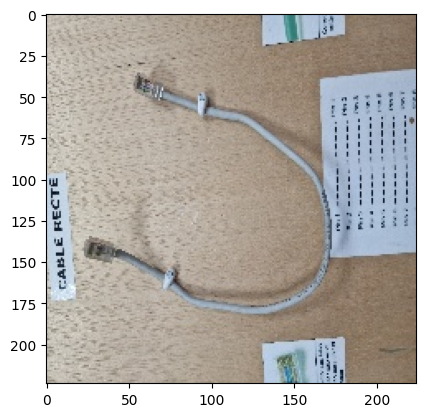

1/1 [==============================] - 7s 7s/step


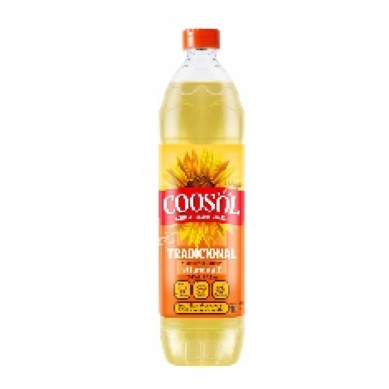

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [3]:
val_image_path = r'Final_dataset_small\Validation\RAEE\0728_20230330_193806_RAEE_NONE.jpg'.replace('\\', '/')
val_image = cv2.imread(val_image_path)

plt.imshow(cv2.cvtColor(val_image, cv2.COLOR_BGR2RGB))
plt.show()
knn_online.predict_show(val_image, 'RAEE')

In [3]:
# Guardamos los features, la url de la imagen y la clase en el mismo fichero
import pickle
from sklearn.neighbors import NearestNeighbors

with open('features.pkl', 'wb') as f:
    pickle.dump(features, f)
    pickle.dump(val_generator.filenames, f)
    pickle.dump(val_generator.classes, f)

# Cargamos los features, la url de la imagen y la clase en el mismo fichero
import pickle
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)
    filenames = pickle.load(f)
    classes = pickle.load(f)

In [ ]:
val_images = r'Final_dataset_small\Validation\Amarillo\1NNPGJBONQ4E.jpg'.replace('\\', '/')
feature = feature_model.predict(val_generator)

[[2.38418579e-07 5.35677281e+00 5.47099075e+00 5.48741322e+00
  5.65065797e+00 5.76659453e+00 5.78724220e+00 5.78747389e+00
  5.86985359e+00 5.89570152e+00]]
['Final_dataset_small\\Train\\Amarillo\\IMG20230220104753.jpg', 'Final_dataset_small\\Train\\Amarillo\\can (634)_.jpg', 'Final_dataset_small\\Train\\Verde\\glass 2414.jpg', 'Final_dataset_small\\Train\\Amarillo\\can (895)_.jpg', 'Final_dataset_small\\Train\\Amarillo\\can (822)_.jpg', 'Final_dataset_small\\Train\\Verde\\glass361.jpg', 'Final_dataset_small\\Train\\Amarillo\\beverage_cans 271.jpg', 'Final_dataset_small\\Train\\Amarillo\\can (598)_.jpg', 'Final_dataset_small\\Train\\Amarillo\\beverage_cans 733.jpg', 'Final_dataset_small\\Train\\Verde\\R_4082.jpg']


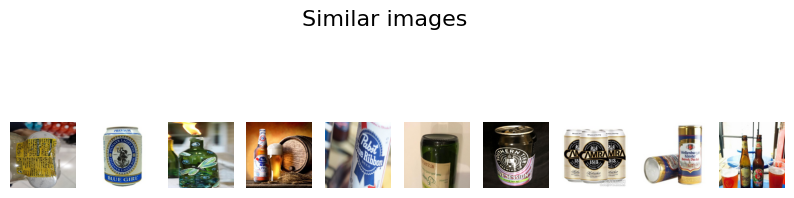

In [9]:
distances, indices = knn.kneighbors(features_scaled[856:857])

print(distances)
plt.
# Plot similar images

fig = plt.figure(figsize=(10, 3))
fig.suptitle('Similar images', fontsize=16)

images_url = [os.path.join(MAIN_PATH, 'Train', val_generator.filenames[i]) for i in indices[0]]
print(images_url)

for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.axis('off')
    ax.imshow(plt.imread(images_url[i]))

plt.show()
